In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import time, timedelta

print("Cargando datos procesados desde archivos Parquet...")
try:
    viajes = pd.read_parquet('../data/interim/viajes.parquet')
    estaciones = pd.read_parquet('../data/interim/estaciones.parquet')
    snapshots = pd.read_parquet('../data/interim/snapshots.parquet')
    print("Datos cargados exitosamente.")
except FileNotFoundError as e:
    print(f"ERROR: No se encontró el archivo {e.filename}.")
    print("Asegúrate de haber ejecutado la celda final del notebook del Paso 1 para crear los archivos .parquet.")
    raise

Cargando datos procesados desde archivos Parquet...
Datos cargados exitosamente.


In [78]:
 #1. Unir Viajes con Estaciones para obtener la colonia
print("\nUniendo 'viajes' y 'estaciones'...")
viajes_con_colonia = pd.merge(
    viajes, 
    estaciones[['id_estacion', 'colonia']], 
    left_on='id_estacion_retiro',
    right_on='id_estacion',
    how='left'
)



# 2. Filtrar por las colonias de interés
colonias_interes = ['San Miguel Chapultepec', 'Hipodromo Condesa', 'Condesa', 'Escandon']
estaciones_filtradas = estaciones[estaciones['colonia'].isin(colonias_interes)]
id_estaciones_interes = estaciones_filtradas['id_estacion'].unique()
viajes_filtrados = viajes_con_colonia[viajes_con_colonia['colonia'].isin(colonias_interes)].copy()
snapshots = snapshots[snapshots['id_estacion'].isin(id_estaciones_interes)].copy()

print(f"\nSe encontraron {len(viajes_filtrados)} viajes en las colonias de interés.")



Uniendo 'viajes' y 'estaciones'...

Se encontraron 130341 viajes en las colonias de interés.


In [79]:
viajes_lv = viajes_filtrados[viajes_filtrados['fecha_retiro'].dt.weekday < 5].copy()
viajes_fds = viajes_filtrados[viajes_filtrados['fecha_retiro'].dt.weekday >= 5].copy()

print(f"Viajes de Lunes a Viernes (LV): {len(viajes_lv)}")
print(f"Viajes de Sábado a Domingo (FDS): {len(viajes_fds)}")


Viajes de Lunes a Viernes (LV): 103419
Viajes de Sábado a Domingo (FDS): 26922



Calculando throughput promedio para LV y FDS...
Generando gráficas de throughput...


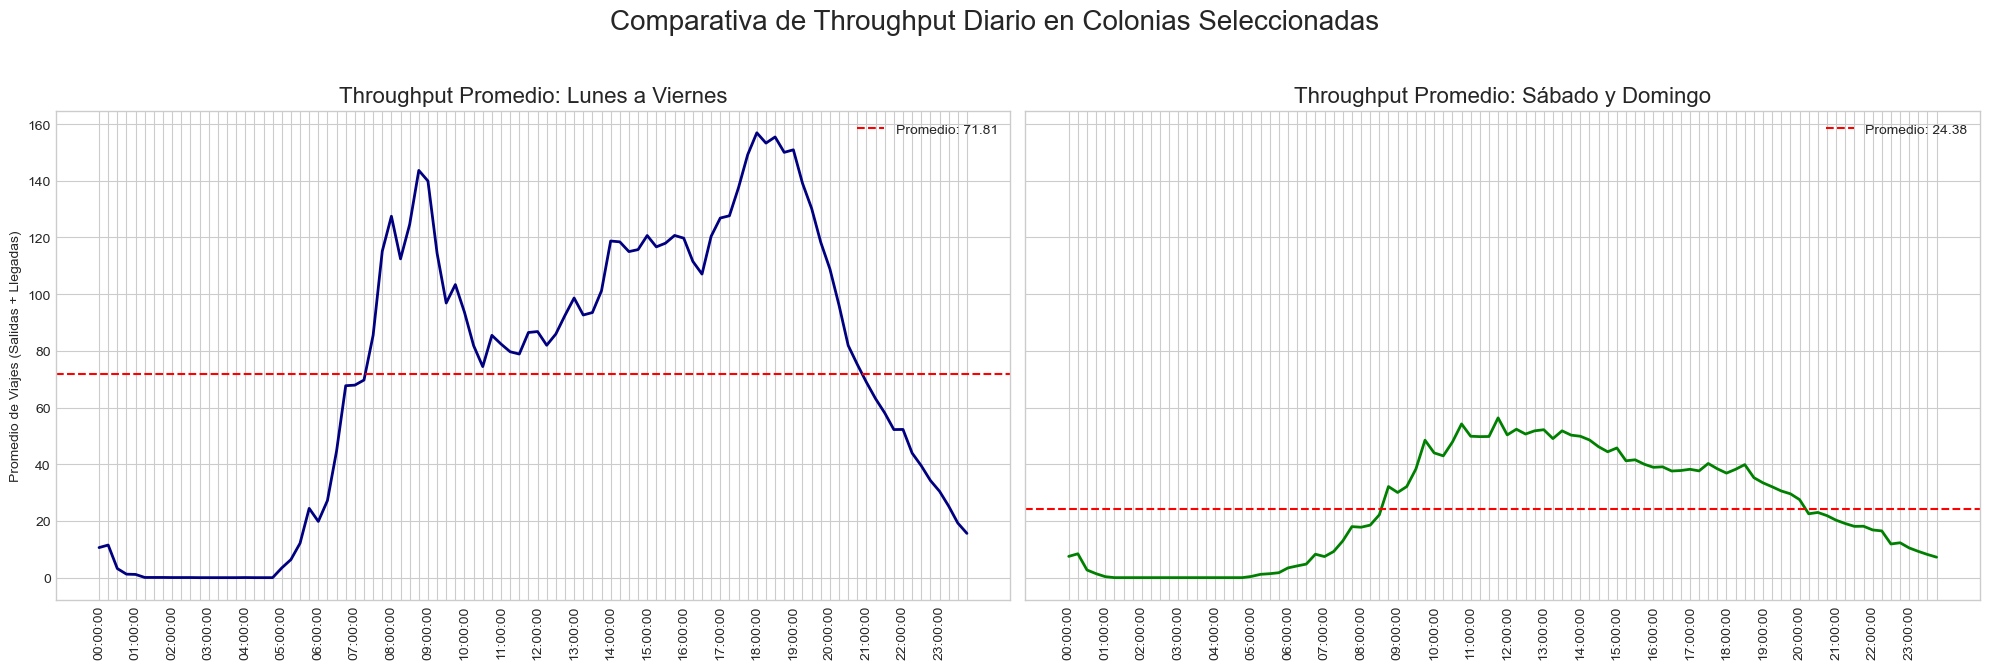

In [80]:
def calcular_throughput_promedio(df_viajes):
    if df_viajes.empty: return pd.Series(dtype=float)
    # Resample a 15 min y contar viajes
    salidas = df_viajes.set_index('fecha_retiro').resample('15min').size()
    llegadas = df_viajes.set_index('fecha_arribo').resample('15min').size()
    # Unir salidas y llegadas, rellenar ceros y sumar
    throughput = pd.concat([salidas, llegadas], axis=1).fillna(0)
    throughput['total'] = throughput.sum(axis=1)
    # Agrupar por hora del día y calcular el promedio
    return throughput.groupby(throughput.index.time)['total'].mean()

print("\nCalculando throughput promedio para LV y FDS...")
throughput_lv = calcular_throughput_promedio(viajes_lv)
throughput_fds = calcular_throughput_promedio(viajes_fds)

# --- 5. VISUALIZACIÓN DE RESULTADOS ---
print("Generando gráficas de throughput...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
fig.suptitle('Comparativa de Throughput Diario en Colonias Seleccionadas', fontsize=20)

# Gráfico Lunes a Viernes
axes[0].plot(throughput_lv.index.astype(str), throughput_lv.values, color='navy', linewidth=2)
axes[0].axhline(throughput_lv.mean(), color='red', linestyle='--', label=f'Promedio: {throughput_lv.mean():.2f}')
axes[0].set_title('Throughput Promedio: Lunes a Viernes', fontsize=16)
axes[0].set_ylabel('Promedio de Viajes (Salidas + Llegadas)')
axes[0].legend()

# Gráfico Fin de Semana
axes[1].plot(throughput_fds.index.astype(str), throughput_fds.values, color='green', linewidth=2)
axes[1].axhline(throughput_fds.mean(), color='red', linestyle='--', label=f'Promedio: {throughput_fds.mean():.2f}')
axes[1].set_title('Throughput Promedio: Sábado y Domingo', fontsize=16)
axes[1].legend()

# Formateo de ejes para ambos gráficos
for ax in axes:
    ax.tick_params(axis='x', rotation=90)
    for index, label in enumerate(ax.get_xticklabels()):
        if index % 4 != 0: label.set_visible(False)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [81]:
 """
    Analiza una serie de tiempo de throughput y devuelve las franjas
    donde el valor supera el umbral.
    """
 # Crear una serie booleana: True si está por encima del umbral, False si no
# Usamos diff() para encontrar los puntos donde cambia de estado (de normal a pico y viceversa)
    # Un cambio de 0 a 1 (False a True) es un inicio de pico.
    # Un cambio de 1 a 0 (True a False) es un fin de pico.
# Caso especial: si la serie empieza ya en pico
# Caso especial: si la serie termina en pico
def encontrar_franjas_pico(throughput_series, umbral):
    es_pico = throughput_series > umbral
    cambios = es_pico.astype(int).diff()
    inicios_pico = throughput_series.index[cambios == 1]
    fines_pico = throughput_series.index[cambios == -1]
    if es_pico.iloc[0]: inicios_pico = inicios_pico.insert(0, throughput_series.index[0])
    if es_pico.iloc[-1]: fines_pico = fines_pico.append(pd.Index([throughput_series.index[-1]]))
    min_len = min(len(inicios_pico), len(fines_pico))
    return list(zip(inicios_pico[:min_len], fines_pico[:min_len]))


In [82]:

umbral_pico = 100
franjas_pico_lv = encontrar_franjas_pico(throughput_lv, umbral_pico)
print(f"\nUmbral de Hora Pico definido en: {umbral_pico} viajes.")
print("Franjas Pico encontradas para Lunes a Viernes:")
for i, (inicio, fin) in enumerate(franjas_pico_lv):
    fin_real = (pd.to_datetime(str(fin)) + timedelta(minutes=15)).time()
    print(f"  -> Franja {i+1}: de {inicio.strftime('%H:%M')} a {fin_real.strftime('%H:%M')}")




Umbral de Hora Pico definido en: 100 viajes.
Franjas Pico encontradas para Lunes a Viernes:
  -> Franja 1: de 07:45 a 09:45
  -> Franja 2: de 09:45 a 10:15
  -> Franja 3: de 13:45 a 20:30


In [83]:

def etiquetar_vectorizado(df, col_fecha, franjas_lv):
    fechas = df[col_fecha]
    dia_semana = fechas.dt.weekday
    hora_dia = fechas.dt.time
    
    condiciones = [(dia_semana >= 5), (dia_semana < 5)]
    opciones = ['fds', 'normal_lv']
    df['franja_operativa'] = np.select(condiciones, opciones, default='invalido')

    if franjas_lv:
        es_lv = (dia_semana < 5)
        # Crear una máscara booleana para cada franja pico y unirlas con OR (|)
        mascara_total_pico = pd.Series(False, index=df.index)
        for inicio, fin in franjas_lv:
            fin_real = (pd.to_datetime(str(fin)) + timedelta(minutes=15)).time()
            mascara_total_pico |= (es_lv & (hora_dia >= inicio) & (hora_dia < fin_real))
        
        df.loc[mascara_total_pico, 'franja_operativa'] = 'pico_lv'
    return df



In [84]:
print("\nEtiquetando los datos filtrados con las 3 franjas operativas...")
viajes = etiquetar_vectorizado(viajes, 'fecha_retiro', franjas_pico_lv)
snapshots = etiquetar_vectorizado(snapshots, 'run_ts', franjas_pico_lv)

# --- VERIFICACIÓN Y GUARDADO ---
print("\n--- Conteo final por franja operativa ---")
print("\nViajes:")
print(viajes['franja_operativa'].value_counts())
print("\nSnapshots:")
print(snapshots['franja_operativa'].value_counts())

viajes.to_parquet('../data/interim/viajes_final.parquet')
snapshots.to_parquet('../data/interim/snapshots_final.parquet')
estaciones_filtradas.to_parquet('../data/interim/estaciones_final.parquet')





Etiquetando los datos filtrados con las 3 franjas operativas...

--- Conteo final por franja operativa ---

Viajes:
franja_operativa
pico_lv      905885
normal_lv    491483
fds          330619
Name: count, dtype: int64

Snapshots:
franja_operativa
normal_lv    4300
pico_lv      1600
Name: count, dtype: int64


In [96]:
!jupyter nbconvert --to html "001_Franjas.ipynb"

[NbConvertApp] Converting notebook 001_Franjas.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 450554 bytes to 001_Franjas.html
